<a href="https://colab.research.google.com/github/Jumabek/net_intrusion_detection/blob/transformer/Comparing_otimizers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown --id 1-t3RdDpmqMs4ABt9oobSapeNYTZJ9tpu
!unzip MachineLearningCSV.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-t3RdDpmqMs4ABt9oobSapeNYTZJ9tpu
To: /content/MachineLearningCSV.zip
100% 235M/235M [00:01<00:00, 170MB/s]
Archive:  MachineLearningCSV.zip
   creating: MachineLearningCVE/
  inflating: MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv  
  inflating: MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv  
  inflating: MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv  
  inflating: MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv  
  inflating: MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv  
  inflating: MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv  
  inflating: MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv  
  in

In [ ]:
!wget https://raw.githubusercontent.com/Jumabek/net_intrusion_detection/develop/preprocessing.py

--2023-08-06 03:57:26--  https://raw.githubusercontent.com/Jumabek/net_intrusion_detection/develop/preprocessing.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3790 (3.7K) [text/plain]
Saving to: ‘preprocessing.py’

preprocessing.py    100%[===================>]   3.70K  --.-KB/s    in 0s      

2023-08-06 03:57:26 (69.5 MB/s) - ‘preprocessing.py’ saved [3790/3790]



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from preprocessing import load_data, balance_data, normalize
import pandas as pd
import numpy as np
from torch.optim import Adam, SGD, Adagrad, RMSprop, AdamW
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
dataroot = 'MachineLearningCVE/'
from preprocessing import read_data
data = read_data(dataroot,'*.pcap_ISCX.csv')

[########################################] | 100% Completed | 29.19 s


In [ ]:
# Load, balance and normalize the data
X, y = load_data(dataroot)
X, y = balance_data(X, y, seed=42)
X = normalize(X)

[########################################] | 100% Completed | 28.66 s
there are 2830743 flow records with 79 feature dimension
stripped column names
dropped bad columns
There are 0 nan entries
converted to numeric


In [ ]:
# Use only 10% of the data
sample_idx = np.random.choice(len(X), int(0.1*len(X)), replace=False)
X = X[sample_idx]
y = y[sample_idx]

In [ ]:
# Split the data into training and remaining sets first
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Split the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42)

# Convert the data into PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create PyTorch Datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=64, nhead=8, num_layers=5, dim_feedforward=128, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)  # Add a fake batch dimension for the transformer
        x = self.transformer(x, x)  # Encoder-Decoder Self-Attention
        x = x.squeeze(1)
        x = self.fc(x)
        return x


def evaluate_model(model, data_loader):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for data, labels in data_loader:
            data = data.cuda()
            labels = labels.cuda()

            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')

    return accuracy, f1, precision, recall


In [ ]:
def train_model(optimizer):
    # Model Configuration
    input_dim = X_train.shape[1]
    num_classes = len(np.unique(y))
    model = TransformerModel(input_dim, num_classes, num_layers=2)
    model = model.cuda()

    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer(model.parameters(), lr=0.001)

    # Dataloader with new batch size
    batch_size = 5120
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    for epoch in range(10):
        model.train()
        running_loss = 0.0
        for i, (data, labels) in enumerate(train_loader):
            data = data.cuda()  # Move data to GPU
            labels = labels.cuda()  # Move labels to GPU

            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Optimizer: {optimizer.__class__.__name__}, Epoch [{epoch + 1}/10], Loss: {running_loss / len(train_loader):.4f}')

    # Validation
    model.eval()
    with torch.no_grad():
        outputs = model(X_test.cuda())
    _, predicted = torch.max(outputs, 1)

    acc = accuracy_score(y_test.cpu(), predicted.cpu())
    f1 = f1_score(y_test.cpu(), predicted.cpu(), average='weighted')
    prec = precision_score(y_test.cpu(), predicted.cpu(), average='weighted')
    rec = recall_score(y_test.cpu(), predicted.cpu(), average='weighted')

    return acc, f1, prec, rec



In [ ]:
# Create a dictionary of optimizers
optimizers_dict = {
    'Adam': Adam,
    'SGD': SGD,
    'Adagrad': Adagrad,
    'RMSprop': RMSprop,
    'AdamW': AdamW
}

# Lists to store metrics for each model configuration
accuracies = []
f1_scores = []
precisions = []
recalls = []


for opt in optimizers_dict.values():
    acc, f1, prec, rec = train_model(opt)
    accuracies.append(acc)
    f1_scores.append(f1)
    precisions.append(prec)
    recalls.append(rec)


Optimizer: Adam, Epoch [1/10], Loss: 1.6241
Optimizer: Adam, Epoch [2/10], Loss: 0.7198
Optimizer: Adam, Epoch [3/10], Loss: 0.5012
Optimizer: Adam, Epoch [4/10], Loss: 0.3930
Optimizer: Adam, Epoch [5/10], Loss: 0.3460
Optimizer: Adam, Epoch [6/10], Loss: 0.3383
Optimizer: Adam, Epoch [7/10], Loss: 0.2968
Optimizer: Adam, Epoch [8/10], Loss: 0.2853
Optimizer: Adam, Epoch [9/10], Loss: 0.2615
Optimizer: Adam, Epoch [10/10], Loss: 0.2611
Optimizer: SGD, Epoch [1/10], Loss: 2.7751
Optimizer: SGD, Epoch [2/10], Loss: 2.6977
Optimizer: SGD, Epoch [3/10], Loss: 2.6393
Optimizer: SGD, Epoch [4/10], Loss: 2.5779
Optimizer: SGD, Epoch [5/10], Loss: 2.5060
Optimizer: SGD, Epoch [6/10], Loss: 2.4276
Optimizer: SGD, Epoch [7/10], Loss: 2.3505
Optimizer: SGD, Epoch [8/10], Loss: 2.2749
Optimizer: SGD, Epoch [9/10], Loss: 2.2054
Optimizer: SGD, Epoch [10/10], Loss: 2.1397
Optimizer: Adagrad, Epoch [1/10], Loss: 1.9957
Optimizer: Adagrad, Epoch [2/10], Loss: 1.3724
Optimizer: Adagrad, Epoch [3/10], 

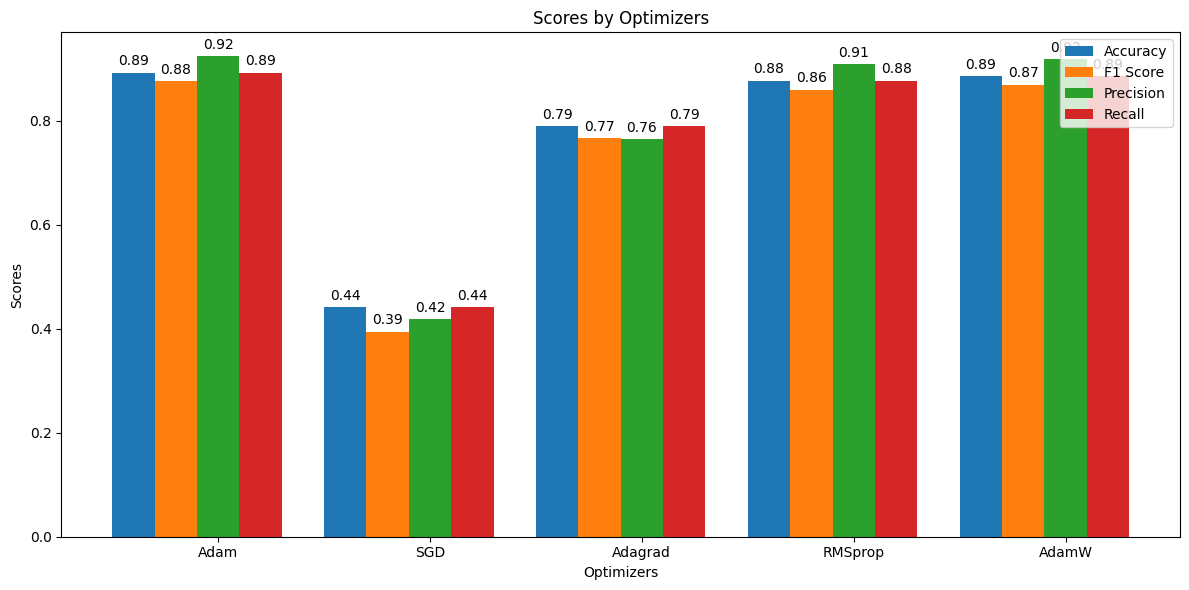

In [ ]:
# Plotting the metrics
import matplotlib.pyplot as plt
import numpy as np

# Create an index for each tick position
x_indexes = np.arange(len(optimizers_dict.keys()))
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Generate bar graphs
rects1 = ax.bar(x_indexes - 2 * width, accuracies, width, label='Accuracy')
rects2 = ax.bar(x_indexes - width, f1_scores, width, label='F1 Score')
rects3 = ax.bar(x_indexes, precisions, width, label='Precision')
rects4 = ax.bar(x_indexes + width, recalls, width, label='Recall')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Optimizers')
ax.set_ylabel('Scores')
ax.set_title('Scores by Optimizers')
ax.set_xticks(x_indexes)
ax.set_xticklabels(optimizers_dict.keys())
ax.legend()

# Attach a text label above each bar in *rects*, displaying its height
for rects in [rects1, rects2, rects3, rects4]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

fig.tight_layout()

plt.show()


In [ ]:
print("optimizers:", optimizers_dict )
print("accuracies:", accuracies)
print("f1_scores:", f1_scores)
print("precisions:", precisions)
print("recalls:", recalls)

optimizers: {'Adam': <class 'torch.optim.adam.Adam'>, 'SGD': <class 'torch.optim.sgd.SGD'>, 'Adagrad': <class 'torch.optim.adagrad.Adagrad'>, 'RMSprop': <class 'torch.optim.rmsprop.RMSprop'>, 'AdamW': <class 'torch.optim.adamw.AdamW'>}
accuracies: [0.892727615279544, 0.4411709293014931, 0.7900946728839904, 0.8771607554990344, 0.8861099335876784]
f1_scores: [0.8761451351128046, 0.39462856708414684, 0.7658564502518753, 0.8600628161028294, 0.8695239078288123]
precisions: [0.9238137159664936, 0.4183957487540065, 0.764809420636193, 0.9087179576246182, 0.9187687330646684]
recalls: [0.892727615279544, 0.4411709293014931, 0.7900946728839904, 0.8771607554990344, 0.8861099335876784]
